In [2]:
import cv2 as cv #opencv controll images read ,write or show
import numpy as np # deal with arries
import os #conteol folders and access images
import skimage.color # convert image from rgb to graylevel we can use opencv for this step
from matplotlib import pyplot as plt #plot the images beside each other
from sklearn.metrics import jaccard_score #get the jaccard index
from skimage import measure
import pandas as pd
from scipy.fft import fft2, fftshift
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import ast
from sklearn.model_selection import train_test_split

In [3]:
database_path='_Output'
database_of_truth_path='_GroundTruth'
database_of_MyWork_path='output_mywork'
folder_names = os.listdir(database_path)

In [4]:
folder_names=folder_names[:]
folder_names

['Alstonia_Scholaris_(P2)', 'Arjun_(P1)']

In [5]:
def get_images(database_path,folder_name): 
    images_of_folder = os.listdir('{}/{}'.format(database_path,folder_name))
    return images_of_folder
    

In [6]:
def phase1Function(database_path,folder_name):
    # Reading The  First Folder
    list_of_images = get_images(database_path,folder_name)
    alpha = 4 # Simple contrast control
    beta = 14  # Simple brightness control
    kernel = np.ones((10,10),np.uint8) #the kernel which is in the openning operation
    totaljaccard=0
    
    for i in range(len(list_of_images)):
        img = cv.imread('{}/{}/{}' .format(database_path,folder_name,list_of_images[i]))
        median = cv.medianBlur(img, 3)#removing the affect of the salt and papier
        new_image = np.zeros(img.shape, img.dtype)      #create a new image with the same shape and type of the original image
        new_image = cv.addWeighted(median, alpha, new_image, 0, beta)       #change the original image contrast and brightness and put it in the new image 
    # convert the image to grayscale
        gray_image = skimage.color.rgb2gray(new_image)      # the new image with a grayscale 
     
        # print(gray_image)
    #the tresholding and make the segmantaion processes
        t = .4
        binary_mask = gray_image> t
        
        
        binary_mask_after_astype = binary_mask.astype('uint8')
    #the openning to make the segmantation better
        opening = np.zeros(binary_mask.shape, binary_mask.dtype)
        opening = cv.morphologyEx(binary_mask_after_astype, cv.MORPH_OPEN, kernel)
        final_image=opening
       
       
        plt.subplot(121), plt.imshow(final_image , cmap='gray'), plt.title('binary_mask-my-work',fontsize=10,color='b')
        plt.xticks([]), plt.yticks([])
        img_truth = cv.imread('{}/{}/{}' .format(database_of_truth_path,folder_name,list_of_images[i]))
        gray_image_truth = skimage.color.rgb2gray(img_truth)  
    # blur the image to denoise
        blurred_image_truth = skimage.filters.gaussian(gray_image_truth, sigma=1.0) 
    
        binary_mask_truth = blurred_image_truth > t 
        plt.subplot(122), plt.imshow(binary_mask_truth,cmap='gray'), plt.title('binary_mask_truth',fontsize=10,color='b')
        plt.xticks([]), plt.yticks([]) 
        img_true=np.array(opening).ravel()
        img_pred=np.array(binary_mask_truth).ravel()
        iou = jaccard_score(img_true, img_pred)
        totaljaccard+=iou
        output_folder = "./output_mywork/{}".format(folder_name)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        writePath= "./output_mywork/{}/{}.jpg".format(folder_name,i+1);

    #----------------------Out Put--------
        # print(writePath)
        cv.imwrite(writePath, opening)
        # plt.show()
    # average=totaljaccard/len(list_of_images)
    # print(average)
        
        
        

In [7]:
def get_the_fourier_descriptor(binary_image):
   
# Find contours of the binary image
    # print(binary_image)
    # cv.imshow('output',binary_image)
    contours, _ = cv.findContours(binary_image, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_SIMPLE)
    print(contours)
# Get Fourier descriptor
    fourier_descriptor = fft2(contours)
    fourier_descriptor = fftshift(fourier_descriptor)
    return fourier_descriptor

In [8]:


# segmented_image is a binary image where the white blood cell is represented by 1's and the background is represented by 0's
def phase2Function(database_of_MyWork_path,folder_name,data):
    list_of_images = get_images(database_of_MyWork_path,folder_name)
    for i in range(len(list_of_images)):
        img = cv.imread('{}/{}/{}' .format(database_of_MyWork_path,folder_name,list_of_images[i]))
        img=img.transpose(2,0,1).reshape(3,-1)
        # print(img.shape)
        img_label=measure.label(img)
        
        # extract properties
        properties = measure.regionprops(img_label)
        # fourier_descriptor=get_the_fourier_descriptor(img)
        # print(properties[0])
        area = properties[0].area # extract the area
        perimeter = properties[0].perimeter # extract the perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2) # extract the circularity
        eccentricity = properties[0].eccentricity # extract the eccentricity
        # fourier_descriptors=get_the_fourier_descriptor(img)
        invariant_moments = properties[0].moments_hu # extract the invariant moments
       
        data.append({ 'area': area, 
        'perimeter': perimeter, 'circularity': circularity, 

                #  'eccentricity': eccentricity, 
                 'invariant_moments': invariant_moments
                #  , 'fourier_descriptors': fourier_descriptors
                 ,'Class': folder_name,})

    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv('dataset.csv', index=False)



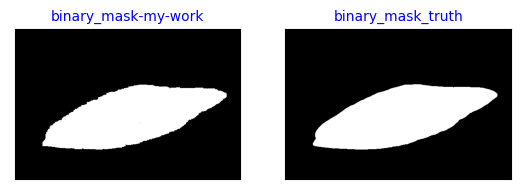

In [9]:
data=[]
for folder in folder_names:
    phase1Function(database_path,folder)
    phase2Function(database_of_MyWork_path,folder,data)

In [10]:
df = pd.read_csv('dataset.csv')

In [11]:
new_value=[]
the_avrage=[]
def convert_INvariant_momnets(values):
    for i in range(len (values)):
        new_value.append(values[i].split(' ') )
    
    # print(float(new_value[i][0][1:]))
    for i in range(len(values)):
        if (new_value[i][0][1:]!='' and new_value[i][1] !=''):
            the_avrage.append((float(new_value[i][0][1:])+float(new_value[i][1]))/2)
        else :
            the_avrage.append(0)
    return the_avrage
    

In [12]:
df['invariant_moments']=convert_INvariant_momnets(df['invariant_moments'].values)

In [13]:
df['invariant_moments'].head()

0    0.10735
1    0.00000
2    0.00000
3    0.00000
4    0.00000
Name: invariant_moments, dtype: float64

In [14]:
df.head()

,area,perimeter,circularity,invariant_moments,Class
0,18,14.0,1.154054,0.10735,Alstonia_Scholaris_(P2)
1,1545,1032.0,0.018230,0.00000,Alstonia_Scholaris_(P2)
2,1398,934.0,0.020138,0.00000,Alstonia_Scholaris_(P2)
3,1374,918.0,0.020489,0.00000,Alstonia_Scholaris_(P2)
4,1575,1052.0,0.017884,0.00000,Alstonia_Scholaris_(P2)


In [15]:
X=df.iloc[:,0:-1]
y=df['Class']

In [16]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [17]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [18]:
svc = SVC(C=1, kernel='linear')
model = svc.fit(X_train, y_train)
predicted = cross_val_predict(model, X_train, y_train, cv=2)
print ("accuracy",metrics.accuracy_score(y_train, predicted))
print ("f1 score macro",metrics.f1_score(y_train, predicted, average='macro') )
print ("f1 score micro",metrics.f1_score(y_train, predicted, average='micro') )
print ("precision score",metrics.precision_score(y_train, predicted, average='macro') )
print ("recall score",metrics.recall_score(y_train, predicted, average='macro') )

accuracy 0.8903225806451613
f1 score macro 0.8836952683615817
f1 score micro 0.8903225806451613
precision score 0.9157711161387632
recall score 0.8740247625508819


In [20]:
predicted = cross_val_predict(model, X_test, y_test, cv=2)
print ("accuracy",metrics.accuracy_score(y_test, predicted))
print ("f1 score macro",metrics.f1_score(y_test, predicted, average='macro') )
print ("f1 score micro",metrics.f1_score(y_test, predicted, average='micro') )
print ("precision score",metrics.precision_score(y_test, predicted, average='macro') )
print ("recall score",metrics.recall_score(y_test, predicted, average='macro') )

accuracy 0.8846153846153846
f1 score macro 0.8845964162419859
f1 score micro 0.8846153846153846
precision score 0.8862887277521424
recall score 0.8855263157894737
